# Analysing Scotland's land cover change using python  


Scotland's land cover change will be analysed using  raster datasets derived from the [UKCEH Land Cover Map Products](https://www.ceh.ac.uk/ukceh-land-cover-maps). In particular, the changes between the years 2017, 2019, and 2021 will be analysed to see whether there has been any immediate changes prior to Scotland's pledge towards the Net Zero reforestation targets (2017), and the years after (2021). For the mapping element, the raster dataset will also be combined with the the digital vector dataset of the UK's Counties and Unitary authority boundaries from the [ONS Geography](https://geoportal.statistics.gov.uk/datasets/ons::counties-and-unitary-authorities-april-2019-boundaries-gb-bgc/about) . These feature polygons that spatially map out Scotland. 


A mixture of barcharts, sankey diagrams, and choropleth maps will be implemented to illustrate the different ways in which the Scotland's land cover change can be communicated. 

## Table of Contents 

Add all the different parts of the setup 

<a name="section0"></a>
## 0. Data Setup and Wrangling 

Have to import all the required packages for the analysis of land cover changes.

In [17]:
import rasterio as rio
import rasterio.mask
from rasterio.plot import show
#from descartes import PolygonPatch

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

import plotly.graph_objects as go

import seaborn as sns
import fiona
import pandas as pd
import geopandas as gpd
import numpy as np
import copy

from sklearn import metrics
from rasterstats import zonal_stats

print ('done')

done


### Reading in the raster data 

The years for the land cover changes that we are interested in analysing are 2017, 2019, and 2021. So, the raster dataset is read in using rasterio's 'open' function. 

In [5]:
lcm2021 = rio.open("data/output/gb2021lcm1km_dominant_target.tif")
lcm2019 = rio.open("data/output/gb2019lcm1km_dominant_target.tif")
lcm2017 = rio.open("data/output/gb2017lcm1km_dominant_target.tif")

### Reading in the vector polygon data 

To spatially map the land cover changes according to unitary authorities/counties, the vector polygons need to be read in as well - using GeoPandas. 

In [6]:
GB = gpd.read_file('data/output/Counties_and_Unitary_Authorities_April2019_GB_BGC_osbg.geojson').set_index('ctyua19nm')
GB.head()

,objectid,ctyua19cd,ctyua19nmw,bng_e,bng_n,long,lat,st_areashape,st_lengthshape,geometry
ctyua19nm,,,,,,,,,,
Hartlepool,1,E06000001,,447157,531476,-1.27023,54.676159,9.364022e+07,69232.916248,"MULTIPOLYGON (((449613.69168 526077.14023, 449..."
Middlesbrough,2,E06000002,,451141,516887,-1.21099,54.544670,5.387847e+07,42081.032562,"MULTIPOLYGON (((451788.84155 520487.74895, 451..."
Redcar and Cleveland,3,E06000003,,464359,519597,-1.00611,54.567520,2.448736e+08,96004.895063,"MULTIPOLYGON (((451788.37175 520493.73655, 451..."
Stockton-on-Tees,4,E06000004,,444937,518183,-1.30669,54.556911,2.049584e+08,115262.590755,"MULTIPOLYGON (((449243.87660 526122.71596, 449..."
Darlington,5,E06000005,,428029,515648,-1.56835,54.535339,1.974976e+08,105784.983937,"POLYGON ((436388.01502 522354.20043, 436282.11..."


Looking through the dataframe, we can see that each row (polygon) represents a different unitary authority in the UK. 

However, to ensure the spatial elements and the land cover classification elements match for these different datasets, some data wrangling is required: 

- re-setting a consistent `CRS` format across all the datasets (raster and vector)
-  setting the `nodata` value to `0.0` in rasters
- modifying dataframe to only include Scotland
- reclassifying the 20+ land cover classes to 6 simplify the land cover changes extent  

### Re-projecting the CRS 

The GeoJSON data format that contains the coordinates for the UK's county boundaries automatically stores these according to the  World Geodetic System 1984 (WGS 84). Whilst, the raster dataset uses the British OSGB 1936 system. So, I updated the CRS using the ESPG code for OSGB 1936, which is 277000. 

In [7]:
GB.crs = "EPSG:27700" 

Checking to see if updated correctly

In [8]:
GB.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

This will be using when mapping out county-level changes to land cover, as the vector polygons need to have the same CRS as the raster dataset to align spatially. 

### Data filtering 

As I am only interested in Scotland's land cover changes, I created a new geodataframe containing only the rows for Scotland. I did this by using the 'ctyua19cd' variable (shows the county/unitary authority). The first letter of this variable indicates the country (England, Scotland, Wales) that the county is located in.

In [9]:
#Now filtering out for just scotland
scotland = GB[GB['ctyua19cd'].str.startswith("S")]
scotland

,objectid,ctyua19cd,ctyua19nmw,bng_e,bng_n,long,lat,st_areashape,st_lengthshape,geometry
ctyua19nm,,,,,,,,,,
Clackmannanshire,152,S12000005,,291159,696335,-3.75344,56.147240,1.589764e+08,9.086602e+04,"MULTIPOLYGON (((290674.509 703671.499, 290009...."
Dumfries and Galloway,153,S12000006,,270645,579857,-4.02863,55.096218,6.437726e+09,1.048454e+06,"MULTIPOLYGON (((207653.609 541738.872, 207676...."
East Ayrshire,154,S12000008,,255398,624935,-4.29057,55.496738,1.270369e+09,3.309121e+05,"POLYGON ((258813.515 645129.307, 258733.010 64..."
East Lothian,155,S12000010,,354854,672351,-2.72435,55.942070,6.792207e+08,1.908342e+05,"MULTIPOLYGON (((351116.011 686149.004, 351032...."
East Renfrewshire,156,S12000011,,251929,653115,-4.36060,55.748680,1.742541e+08,9.178945e+04,"POLYGON ((258954.209 656913.104, 259036.709 65..."
Na h-Eileanan Siar,157,S12000013,,126473,932862,-6.65722,58.199379,3.097613e+09,3.411468e+06,"MULTIPOLYGON (((152086.649 966560.365, 152104...."
Falkirk,158,S12000014,,289661,679536,-3.77060,55.996040,2.973370e+08,1.406551e+05,"POLYGON ((305547.185 679808.595, 305533.810 67..."
Highland,159,S12000017,,241026,858306,-4.66091,57.586689,2.616150e+10,4.774842e+06,"MULTIPOLYGON (((320445.264 976771.967, 320312...."
Inverclyde,160,S12000018,,227922,670899,-4.75387,55.900349,1.619220e+08,7.618663e+04,"POLYGON ((236768.709 673884.948, 236767.814 67..."


So I filtered the Geodataframe to only contain the 'S' rows using the .str.startswith method - thereby, creating a new geodataframe that only contains rows of Scotland's counties. 

I then plotted this Geodataframe to ensure that only Scotland was retained. 

<Axes: >

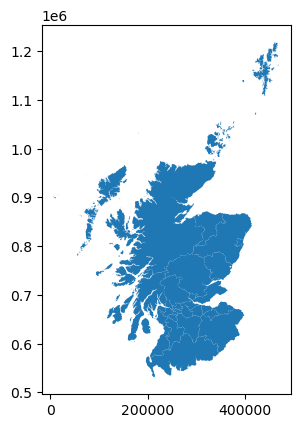

In [10]:
scotland.plot()

Hence only displaying the polygons for Scotland. 

### Alignment of the re-projection 

To ensure that both the datasets are aligned, I plotted the polygon vector dataset on top of the land cover raster dataset. 

This is to ensure that BOTH are using the same CRS system. 

<Axes: >

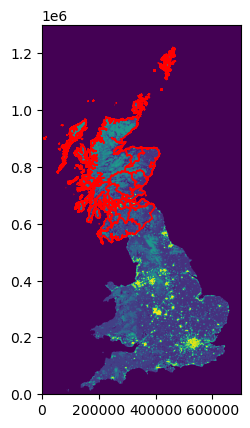

In [11]:
 fig,ax1=plt.subplots(1)
show((lcm2021,1), cmap='viridis',ax=ax1)  #rasterio show, reading the first layer from the DatasetReader object
scotland.plot(ax=ax1, facecolor='None', edgecolor='red', linewidth=1)

As we can see, the CRS re-projection worked! Scotland's polygons align perfectly with the raster dataset. 

### Writing files to disk (for future usage)

This is done by writing my own function to write the  raster dataset. 

In [12]:
#function to write ndarray to file as a .tif (with CRS etc)
def write_nd_to_tif(nd, meta, transform, filename):
    
    #update meta from original to new data extent and transform 
    meta.update({"driver": "GTiff",
                 "height": nd.shape[1],
                 "width": nd.shape[2],
                 "transform": transform})

    with rasterio.open(filename, "w", **meta) as dest:
        dest.write(nd)




The same is done for all the years of interest - 2017, 2019, and 2021

In [13]:
#now for 2021 
lcm2021_scotland, lcm2021_scotland_transform = rasterio.mask.mask(dataset=lcm2021, shapes=scotland.geometry, crop=True)
    
write_nd_to_tif(lcm2021_scotland, lcm2021.meta, lcm2021_scotland_transform, "data/output/lcm2021_scotland.tif")



#now for 2019
lcm2019_scotland, lcm2019_scotland_transform = rasterio.mask.mask(dataset=lcm2019, shapes=scotland.geometry, crop=True)
    
write_nd_to_tif(lcm2019_scotland, lcm2019.meta, lcm2019_scotland_transform, "data/output/lcm2019_scotland.tif")



#now for 2017
lcm2017_scotland, lcm2017_scotland_transform = rasterio.mask.mask(dataset=lcm2017, shapes=scotland.geometry, crop=True)
    
write_nd_to_tif(lcm2017_scotland, lcm2017.meta, lcm2017_scotland_transform, "data/output/lcm2017_scotland.tif")

Now these changes have been saved to file. 

## 1 - Analysing overall land cover change 

In this section, the overall land cover changes will be spatially visualised using the raster datasets previously read in. The current UKCEH raster datasets from the years 2017, 2019, and 2021 contain 20+ different land cover classifications. 

However, as we only interested in understanding the general changes to land covers in Scotland, we can simplify these categories.

### Identifying the different classifications 

Let's first identify the unique values (a.k.a the different classifications), and the number of times they are observed (a.k.a the number of pixels within those land cover classes). 

This can be done using numpy's 'unique' function to count the occurrence of each value (as the data itself are numpy objects, ndarrays): 

In [14]:
unique, counts = np.unique(lcm2021_scotland, return_counts=True)  #get the unique values and counts
counts2021 = dict(zip(unique, counts))                         #combine them into a dict for easier viewing

unique, counts = np.unique(lcm2019_scotland, return_counts=True)
counts2019 = dict(zip(unique, counts))

unique, counts = np.unique(lcm2017_scotland, return_counts=True)
counts2017 = dict(zip(unique, counts))


print(counts2021)
print('\n')
print(counts2019)
print('\n')
print(counts2017)

{0: 243759, 1: 2625, 2: 9678, 3: 6938, 4: 14992, 5: 43, 6: 14, 7: 12795, 8: 20, 9: 8505, 10: 10343, 11: 7310, 12: 1885, 13: 121, 14: 1051, 15: 28, 16: 187, 17: 27, 18: 76, 19: 100, 20: 267, 21: 1242}


{0: 243737, 1: 2232, 2: 9994, 3: 6808, 4: 15490, 5: 12, 7: 12345, 8: 13, 9: 8042, 10: 11664, 11: 6831, 12: 1815, 13: 100, 14: 1044, 15: 27, 16: 183, 17: 39, 18: 64, 19: 94, 20: 261, 21: 1211}


{0: 243733, 1: 2275, 2: 9965, 3: 7152, 4: 15234, 5: 7, 7: 12267, 8: 12, 9: 8531, 10: 11605, 11: 6444, 12: 1812, 13: 107, 14: 976, 15: 33, 16: 197, 17: 22, 18: 60, 19: 96, 20: 268, 21: 1210}


Here we can identify the number of pixels a.k.a the land cover observance that falls within each land cover classification. 

Now let's re-classify this data into a smaller, simpler, classification scheme. 

### Reclassification of land cover 

When reclassifying raster datasets, these will create new rasters with new assigned values. 

To do this we need to first create deep copies of the input raster maps (sing 2d ndarray layer) to hold the new assigned values: 

In [122]:
#create copies of the input raster maps, but only the 2d layer 
lcm2021_scotland2 = copy.deepcopy(lcm2021_scotland[0])
lcm2019_scotland2 = copy.deepcopy(lcm2019_scotland[0])
lcm2017_scotland2 = copy.deepcopy(lcm2017_scotland[0])

print(lcm2021_scotland2.shape)
print(lcm2019_scotland2.shape)
print(lcm2017_scotland2.shape)

(691, 466)
(691, 466)
(691, 466)


This will be re-classified according to this table featured on the UKCEH - [Supporting Documentation](https://doi.org/10.5285/07b6e5e9-b766-48e5-a28c-5b3e35abecc0) for Rowland _et al._ (2020b) as shown in the image below:

<img src="https://www.landscapemodelling.net/png/Table3_Rowland2020.png" width="500px"></img>

Our six simplified classes will therefore be composed of: 
1. Woodland
2. Cropland
3. Grassland
4. Water
5. Built-up
6. Other



This re-classification is important as it defines which values should change to which. 

### Dictionary of assigning old to new 

I created a dictionary to assign the old values to the new values (using the re-classification table above): 



In [123]:
lookup = {1:1,2:1,
          3:2,
          4:3,5:3,6:3,7:3,8:3,9:3,10:3,11:3,16:3,18:3,19:3,
          14:4,
          20:5,21:5,
          12:6,13:6,15:6,17:6}

Nowe we can loop over the `dict` using the key to identify the old values and modify them to the new. 

In [124]:
for old, new in lookup.items(): 
    lcm2021_scotland2[lcm2021_scotland[0] == old]=new
    lcm2019_scotland2[lcm2019_scotland[0] == old]=new
    lcm2017_scotland2[lcm2017_scotland[0] == old]=new

Now we can check to see if this has been successful by examining the unique values and counts of the new raster maps: 

In [125]:
unique, counts = np.unique(lcm2021_scotland2, return_counts=True)  #get the unique values and counts
counts2021_2 = dict(zip(unique, counts))                         #combine them into a dict for easier viewing

unique, counts = np.unique(lcm2019_scotland2, return_counts=True)
counts2019_2 = dict(zip(unique, counts))

unique, counts = np.unique(lcm2017_scotland2, return_counts=True)
counts2017_2 = dict(zip(unique, counts))

#printing out the unique values and counts for the new raster maps 
print(counts2021_2)
print('\n')
print(counts2019_2)
print('\n')
print(counts2017_2)


{0: 243759, 1: 12303, 2: 6938, 3: 54385, 4: 1051, 5: 1509, 6: 2061}


{0: 243737, 1: 12226, 2: 6808, 3: 54738, 4: 1044, 5: 1472, 6: 1981}


{0: 243733, 1: 12240, 2: 7152, 3: 54453, 4: 976, 5: 1478, 6: 1974}



We can see that land covers have now been reassigned according to the new values and alongside this the unique counts! 

However, the classification still requires a corresponding colour scheme and names within the legend to match the classification table. 

### Creating the colours and the legend 

So I defined the colours as a list and converted this to a `ListedColormap` object for matplotlib usage. 7 colours were included as the 'No Data' value still required a colour. 

A legend list of the categorical names was also created (matching the one above), and then combined with the colours list into a `dict`:  

In [126]:
# Define color map of the map legend (because class 6 is missing!)
lc2_colors = ["white", "darkgreen", "lightyellow", "lightgreen", "blue", "black","grey"]
lc2_cmap = ListedColormap(lc2_colors)

#Define class names for the legend
lc2_names = [
    "No Data",
    "Woodland",
    "Cropland",
    "Grassland",
    "Water",
    "Built-up",
    "Other"
]

# use zip to combine two lists into a dict
legend_labels = dict(zip(lc2_colors, lc2_names))

print(legend_labels)

{'white': 'No Data', 'darkgreen': 'Woodland', 'lightyellow': 'Cropland', 'lightgreen': 'Grassland', 'blue': 'Water', 'black': 'Built-up', 'grey': 'Other'}



As we can see the new classifications for the data have now been assigned with the corresponding land cover type and the associated colours. 


Matplotlib `Patch`es is then created using a loop over the `dict`:

In [127]:
#from matplotlib.patches import Patch
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

Now I can plot the 6 different land cover classes in Scotland from the years 2017, 2019, and 2021 using matplotlib. 

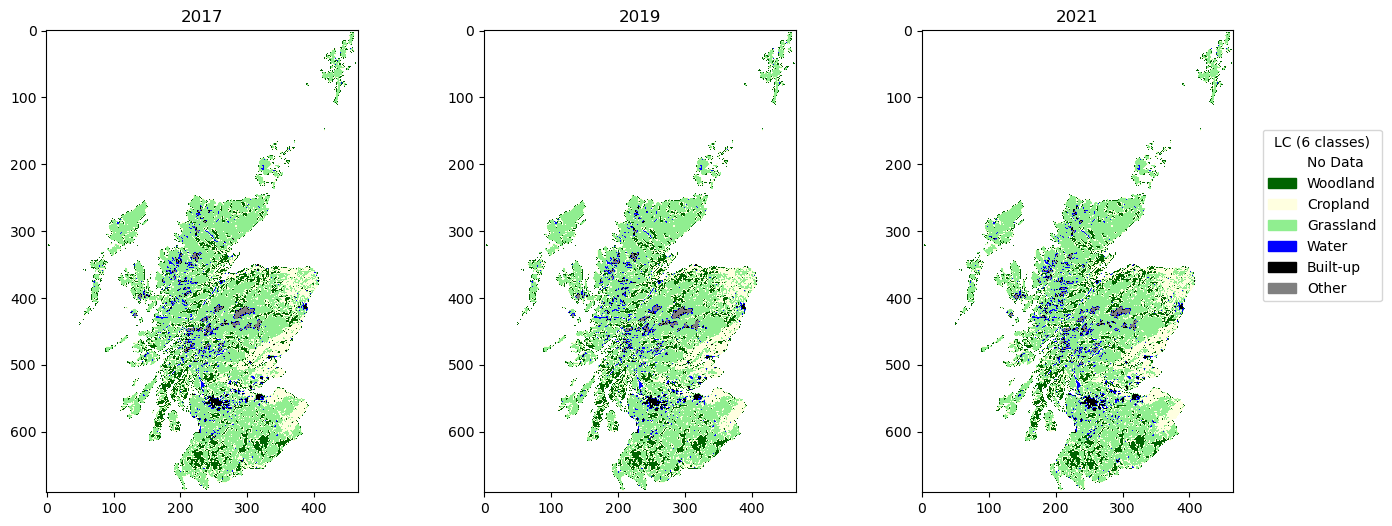

In [128]:
fig, axs = plt.subplots(1, 3, figsize=(16,6))

axs[0].imshow(lcm2017_scotland2, cmap=lc2_cmap)
axs[1].imshow(lcm2019_scotland2, cmap=lc2_cmap)
axs[2].imshow(lcm2021_scotland2, cmap=lc2_cmap)

axs[0].set_title("2017")
axs[1].set_title("2019")
axs[2].set_title("2021")

axs[2].legend(handles=patches,
          bbox_to_anchor=(1.5, 0.8),
          facecolor="white",
             title='LC (6 classes)')

plt.show()

This provides a visual overview of the overall land cover changes throughout those years, and in which geographical regions of Scotland. We can identify that Scotland is made up of a majority of grassland, however, even within the short timeframe we can notice slight differences in land cover.


### Adding re-classified raster data to file 

Now I can add the reclass raster data to file: 

In [130]:
#need to add the dimension we removed using the reshape function 
lcm2021_scotland2_out = lcm2021_scotland2.reshape(1, *lcm2021_scotland2.shape)  

lcm2019_scotland2_out = lcm2019_scotland2.reshape(1, *lcm2019_scotland2.shape) 

lcm2017_scotland2_out = lcm2017_scotland2.reshape(1, *lcm2017_scotland2.shape)

In [131]:
#now can write the 3d raster data to file 
write_nd_to_tif(lcm2021_scotland2_out,  lcm2021.meta, lcm2021_scotland_transform, 
                "data/output/lcm2021_scotland2.tif")

write_nd_to_tif(lcm2019_scotland2_out, lcm2019.meta, lcm2019_scotland_transform, 
                "data/output/lcm2019_scotland2.tif")

write_nd_to_tif(lcm2017_scotland2_out, lcm2017.meta, lcm2017_scotland_transform, 
                "data/output/lcm2017_scotland2.tif")

To get a more accurate, and in-depth understanding of the extent of land cover changes in Scotland, bar-charts are incredibly useful at visualising this with numerical values. 

## 2. Analysing Aggregate Change 

To see the actual extent of the increases and decreases in Scotland's land cover area during those years, bar plots will be produced displaying this. 

### New Dataframe 

Have to create a new dataframe with the cell values: 

In [132]:
#creating a dict containing the land cover labels and add to the Dataframe
lclabs = dict(zip(np.arange(0,7).tolist(), lc5_names))

#create dataframe using from_dict method by passing list of dicts that share keys (they already do )
#Dataframe rotated using .T method for easier plotting with land cover as rows 
counts_df = pd.DataFrame.from_dict([lclabs,counts2017_2,counts2019_2,counts2021_2]).T #ensuring the unique counts and values created before are included 

#Also re-labelling of the columns 
counts_df.columns = ['Land Cover', '2017','2019', '2021']

#As plotting by more than 1 variable (land cover AND year) convert to long format using .melt method
#Also renaming these new columns in this long dataframe 
counts_df_long = pd.melt(counts_df, id_vars=['Land Cover'], value_vars=['2017','2019','2021']) #reshaping it to a long format
counts_df_long.rename(columns={'variable':'Year','value':'cells'}, inplace = True)
counts_df_long

,Land Cover,Year,cells
0,No Data,2017,243733
1,Woodland,2017,12240
2,Cropland,2017,7152
3,Grassland,2017,54453
4,Water,2017,976
5,Built-up,2017,1478
6,Other,2017,1974
7,No Data,2019,243737
8,Woodland,2019,12226
9,Cropland,2019,6808


Now that we have the new dataframe that contains all the value counts of the years (2017, 2019, 2021), we can now plot this.

### Barplot of Total land cover in Scotland during - 2017, 2019, and 2021 

I plotted a bar plot of land area (sq km) by land cover and year using Seaborn's `catplot`:

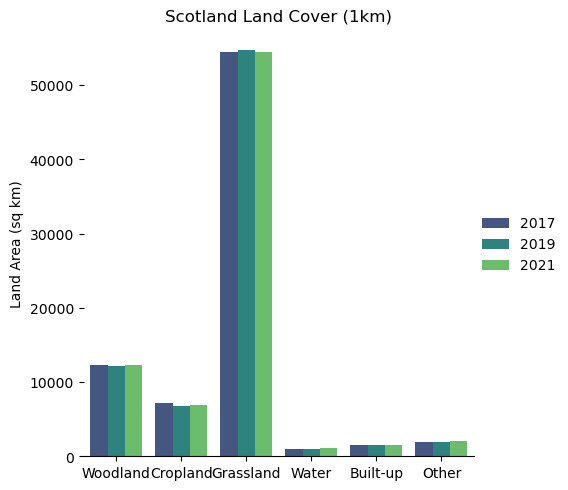

In [133]:
# Nested barplot by land cover and year
g = sns.catplot(
    data=counts_df_long[counts_df_long['Land Cover'] != 'No Data'],   #not plotting the NoData pixels!
    kind="bar",
    x='Land Cover', y='cells', 
    hue="Year",
    palette="viridis"
)
g.despine(left=True)
g.set_axis_labels("", "Land Area (sq km)")
g.legend.set_title("")
plt.title("Scotland Land Cover (1km)")
plt.show()

This bar chart illustrates the total land cover of Scotland and the level of changes to these different land covers over those years. We can see that 'grassland' occupies that largest proportion of land cover, followed by Woodland, Cropland, Other, Built-up and Water. 

However, as the differences in land cover proportions is quite significant, it may be more useful to visualise which land cover areas experienced the greatest diffeerences; and to what extent.

### New dataframes of land cover differences 


So lets create a new column within that dataframe that contains the difference values between the years 2017 to 2019:

In [136]:
counts_df['Diffc-1917'] = counts_df['2019'] - counts_df['2017']
counts_df

,Land Cover,2017,2019,2021,Diffc-1917
0,No Data,243733,243737,243759,4
1,Woodland,12240,12226,12303,-14
2,Cropland,7152,6808,6938,-344
3,Grassland,54453,54738,54385,285
4,Water,976,1044,1051,68
5,Built-up,1478,1472,1509,-6
6,Other,1974,1981,2061,7


Repeat the same thing for the years 2019-2021.

In [137]:
counts_df['Diffc-2119'] = counts_df['2021'] - counts_df['2019']
counts_df

,Land Cover,2017,2019,2021,Diffc-1917,Diffc-2119
0,No Data,243733,243737,243759,4,22
1,Woodland,12240,12226,12303,-14,77
2,Cropland,7152,6808,6938,-344,130
3,Grassland,54453,54738,54385,285,-353
4,Water,976,1044,1051,68,7
5,Built-up,1478,1472,1509,-6,37
6,Other,1974,1981,2061,7,80


We have now added additional columns which contain the values of difference between years 2017-2019, and 2019-2021. These differences were calculated to determine whether there were any significant changes to land cover change and to what extent. 

### Barplot of land cover change in Scotland during - 2017, 2019, and 2021 

Now let's plot the differences in Scotland's land cover change from 2017-2019, using seaborn catplot. 

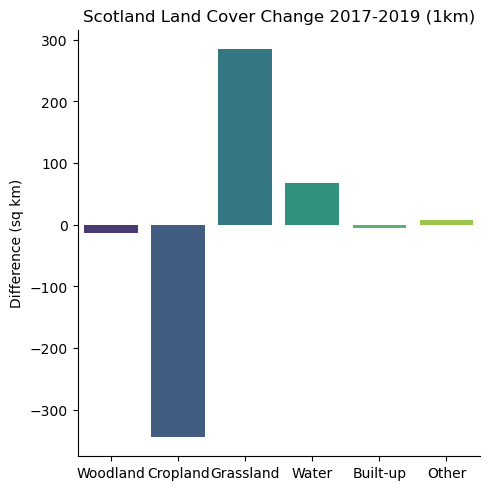

In [138]:
g = sns.catplot(
    data=counts_df[counts_df['Land Cover'] != 'No Data'], 
    kind='bar',
    x='Land Cover', y='Diffc-1917',
    palette="viridis"
)
g.despine()
g.set_axis_labels("", "Difference (sq km)")
plt.title("Scotland Land Cover Change 2017-2019 (1km)")
plt.show()

Let's also do the same for the years 2019-2021: 

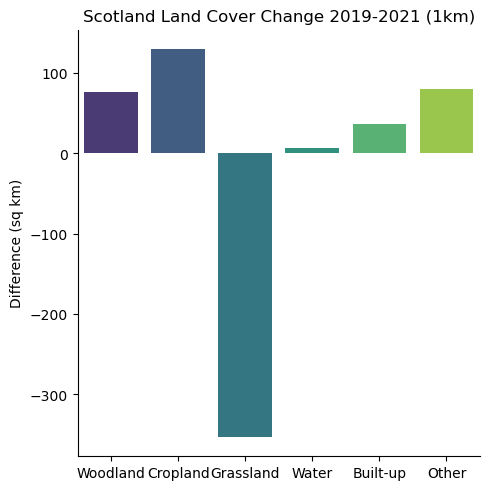

In [139]:
g = sns.catplot(
    data=counts_df[counts_df['Land Cover'] != 'No Data'], 
    kind='bar',
    x='Land Cover', y='Diffc-2119',
    palette="viridis"
)
g.despine()
g.set_axis_labels("", "Difference (sq km)")
plt.title("Scotland Land Cover Change 2019-2021 (1km)")
plt.show()

From this we can see the actual changes to the different land cover types over the years, and to what extent. The bar charts illustrate that during the years 2017-2019, Scotland's Woodland's and Cropland's in particular experienced decreases, whilst the grassland, water, built-up regions and the other category experienced increases. Hence, according to this data, Scotland's Woodlands and Croplands (especially) were diminishing. 

However, this is contrasted with the differences during 2019-2021. Whereby, both those land covers experienced increases, alongside water, built-up areas and other land cover types. In fact, the Grasslands experienced the greatest decrease, despite those land cover regions experiencing the greatest increase in the years prior.

Hence, from this data, it can be inferred that since Scotland's pledges to Net-Zero (2017), greater priority has been given towards Woodlands, resulting in an increase in their land covers in Scotland. Therefore, according to this, these pledges have been effective for Scotland at prioritising their reforestation rates. This has helped determine which land cover areas experienced the most changes and to what extent throughout those years.

### Further analysis 

The downside to these barcharts is that it doessn't provide further information as to which specific land cover types were converted to other types. Hence, we cannot be certain if increased woodland was attributed to reducing grassland or water regions etc. Understanding which land cover regions were converted to other land covers can be useful when looking at land cover management, maintenance of biodiversity habitats etc. 

So other types of visualisations and dataframes could be used alongside this  - e.g. a Sankey Diagram, confusion matrices etc. Thus, the differences in the rate of changes in the years prior to (2017), and post (2021) Net zero pledge can also be identified and examined further. 

## 3. Fine tuned analysis - pixel by pixel change 

The barcharts aggregated the entire raster dataset for Scotland, which we can see the changes to land cover and the extent of those changes between the years (2017-2019-2021). However, we can finetune this and analyse these changes on an even smaller scale e.g. changes to the individual pixels. 

The raster dataset contains pixels which are assigned a specific land cover according to which type of land cover occupies the most of that specified pixel. However, if we are looking at changes over time, we can count the pixel transitions between the different classes - e.g. how many pixels were in Woodland in 2017, but then are in Grassland in 2021 etc. 

These pixel transitions can be calculated using a confusion matrix (a.k.a contingency table)- which can then be visualised into a Sankey Diagram 

### Confusion Matrix - between 2017-2021

Have to do cross tabulation using the `confusion_matrix` function from the `sklearn`package.


This requires flattening the 2d ndarray into 1d for comparison between the two maps: 

In [140]:
lcm2017_scotland2_f = lcm2017_scotland2.flatten()  #flatten from 2d to 1D
lcm2021_scotland2_f = lcm2021_scotland2.flatten()  #flatten from 2d to 1D

print(lcm2021_scotland2_f.shape)

(322006,)


The two flattened maps (1D ndarrays) will be passed to the confusion_matrix function:

In [141]:
#from sklearn import metrics
confND = metrics.confusion_matrix(lcm2017_scotland2_f, lcm2021_scotland2_f)
print(confND.shape)
print('\n')
print(confND)

(7, 7)


[[243676      4      3     46      0      0      4]
 [    10  11285     53    833     23     30      6]
 [     1    108   6157    826      2     49      9]
 [    67    889    686  52184     82     47    498]
 [     0      8      1     25    941      0      1]
 [     2      5     38     50      0   1383      0]
 [     3      4      0    421      3      0   1543]]


We've made a confusion matrix where the 2017 values are in rows, whilst the 2021 values are in columns. However, as the data used still contains the 'No Data' 0 values, with the first rows and columns displaying this. 

Let's remove these to make the contigency table clearer using this function: 

In [142]:
#the function for this: 

def stripFirstRows(mydat):
    
    stripped = np.delete(arr=mydat, obj=0, axis=0)     #delete 0-th row
    stripped = np.delete(arr=stripped, obj=0, axis=1)  #delete 0-th col
    
    return stripped

#then using this function 

conf = stripFirstRows(confND)

print(conf.shape)
print('\n')
print(conf)

(6, 6)


[[11285    53   833    23    30     6]
 [  108  6157   826     2    49     9]
 [  889   686 52184    82    47   498]
 [    8     1    25   941     0     1]
 [    5    38    50     0  1383     0]
 [    4     0   421     3     0  1543]]


To make things even clearer, we can convert this ndarray object into a Pandas DataFrame with labels for rows (e.g.index) and column names:

In [143]:
#better ndarray object
conf_pd = pd.DataFrame(conf,index=lc2_names[1:],columns=lc2_names[1:])
conf_pd

,Woodland,Cropland,Grassland,Water,Built-up,Other
Woodland,11285,53,833,23,30,6
Cropland,108,6157,826,2,49,9
Grassland,889,686,52184,82,47,498
Water,8,1,25,941,0,1
Built-up,5,38,50,0,1383,0
Other,4,0,421,3,0,1543


Now we have a clearly structured contigency table - with the 2017 values as rows, and the 2021 values as columns. Hence we read from the the rows and right to see which cells have transitioned to which land covers between the years 2017-2021. 

As we can see the largest transition towards Woodland land cover in 2021 can be attributed towards Grasslands with 889 cell transitions. However, Woodlands have also been converted to grassland aswell with 833 cells transitioning over (potentially denoting deforestation). Overall though Woodlands have experienced the greater increase due to more of the Scottish grassland being converted to forests via reforestation practices.

These cell transitions across a certain timeframe can be visualised using 'Sankey Diagrams'. 

### Sankey Diagram - between 2017-2021

Sankey Diagrams are a type of flow diagram within wich the arrow widths are proportional to the flow rate.  [source](https://en.wikipedia.org/wiki/Sankey_diagram)

Hence, Sankey Diagrams can help to identify which different land covers are being converted to which others, and to what extent. These are very beneficial at visualising land cover change. 


An outline of the Sankey diagrams will be created using Plotly: 

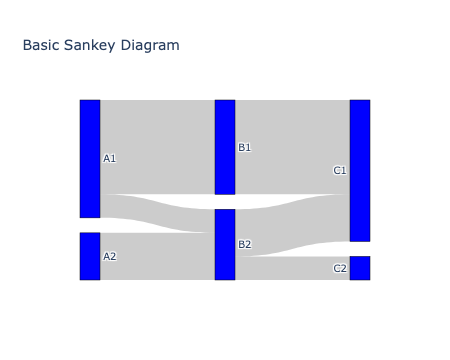

In [144]:
#imported plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["A1", "A2", "B1", "B2", "C1", "C2"],
      color = "blue"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])


fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

This will be used as as the foundation of the Sankey diagram. 


For this sankey diagram, it requires `list`s for the `source`, `target`, and `values` (alongside a label list). The `source` and `target` refer to the specific land cover class IDs used prior, and the values refer to the number of pixels that transition between the different land cover classes. 


Let's create a list of those sources: 

In [145]:
#list of sources 
sourcelc = []
for i in range(0, 6):
    sourcelc += [i] * 6
print(sourcelc)

#then list of targets 
targetlc = list(range(0,6))
targetlc *= 6
print(targetlc)


#then add the corresponding flattened list of transition counts 

conf_list = conf.flatten().tolist()  #conf from above!
print(conf_list)

#then combine those 3 into a dict to specify the link object needed for sankey 

linkslc = dict(source = sourcelc, target = targetlc, value = conf_list)
print(linkslc)

#to visualise the flows from left to right - will use different target IDS from source IDs 
#create new set of target IDs using the values that start from where the Source IDs finished 

targetlc2 = list(range(6,12))
targetlc2 *= 6
print(targetlc2)

#using this in our combined dict for the link 

linkslc2 = dict(source = sourcelc, target = targetlc2, value = conf_list)
print(linkslc2)

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5]
[0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]
[11285, 53, 833, 23, 30, 6, 108, 6157, 826, 2, 49, 9, 889, 686, 52184, 82, 47, 498, 8, 1, 25, 941, 0, 1, 5, 38, 50, 0, 1383, 0, 4, 0, 421, 3, 0, 1543]
{'source': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5], 'target': [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5], 'value': [11285, 53, 833, 23, 30, 6, 108, 6157, 826, 2, 49, 9, 889, 686, 52184, 82, 47, 498, 8, 1, 25, 941, 0, 1, 5, 38, 50, 0, 1383, 0, 4, 0, 421, 3, 0, 1543]}
[6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11]
{'source': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 

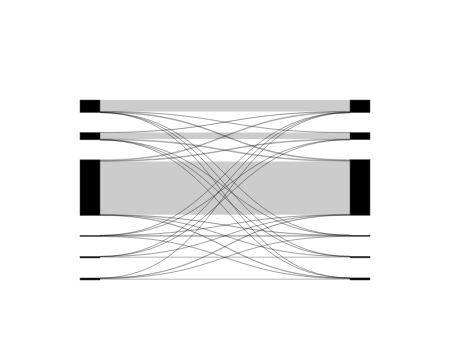

In [146]:
datalc2 = go.Sankey(link = linkslc2)
fig = go.Figure(datalc2)

fig.show()

Starting to see the outline of the various cell transitions between the different land cover classes. 

Let's make it more useful with the attributes in the node dict, firstly by adding the corresponding labels to the sources and targets: 

In [147]:
slabels = lc2_names[1:] + lc2_names[1:]  #[1:] because we removed No Data
slabels 

['Woodland',
 'Cropland',
 'Grassland',
 'Water',
 'Built-up',
 'Other',
 'Woodland',
 'Cropland',
 'Grassland',
 'Water',
 'Built-up',
 'Other']

And now the chosen representative colours in the same order: 

In [148]:
scolors =  lc2_colors[1:] + lc2_colors[1:]  #[1:] because we removed No Data
scolors

['darkgreen',
 'lightyellow',
 'lightgreen',
 'blue',
 'black',
 'grey',
 'darkgreen',
 'lightyellow',
 'lightgreen',
 'blue',
 'black',
 'grey']

After I combined these into a dict to pass to the node argument in the Sankey function: 

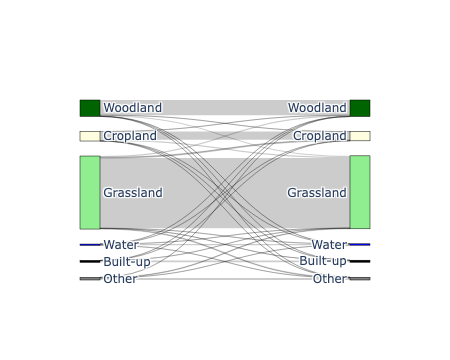

In [149]:
nodelc = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = slabels ,     
      color = scolors
    )

datalc2 = go.Sankey(node=nodelc,link = linkslc2)
fig = go.Figure(datalc2)

fig.show()

By hovering the cursor over the different diagram, we can identify the level of outgoings and to which land covers they have transitioned to. 

From this diagram, very little change of flow can be seen from a specific land cover, to another between 2017-2021. We can see there there has been flow transitions, but not to a significant degree. This can also be attributed to the small timescale as well. Perhaps a longer time scale may have a larger visual difference. 

The number of transition pixels can then be confirmed with the confusion matrix (contingency table) made prior 

### Sankey Diagram - between the transitions from 2017-2019-2021

To see how these flows may have differed prior to Net-Zero targets (2017-2019), and post (2019-2021), a sankey diagram can be created that illustrates the flows from those 2 different time frames. 

This can be done with the same code and process shown above: 

In [150]:
#list of those sources 
source123 = []
for i in range(0, 12):
    source123 += [i] * 6
print(source123)

#then list of targets 
target12 = list(range(6,12))
target12 *= 6

target23 = list(range(12,18))
target23 *= 6
target123 = target12 + target23
print(target123)
#these will help to visualise the flows from left to right - using differnent target IDs from source IDs
#creating new set of target IDs using values starting from where Source IDs finished 

#then add the corresponding flattened list of transition (the years)

lcm2019_scotland2_f = lcm2019_scotland2.flatten()  #flatten from 2d to 1D

lcm2021_scotland2_f = lcm2021_scotland2.flatten()  #flatten from 2d to 1D

conf12 = metrics.confusion_matrix(lcm2017_scotland2_f, lcm2019_scotland2_f)
conf23 = metrics.confusion_matrix(lcm2019_scotland2_f, lcm2021_scotland2_f)

values12 = stripFirstRows(conf12)
values23 = stripFirstRows(conf23)

values12 = values12.flatten().tolist()
values23 = values23.flatten().tolist()

values123 = values12 + values23

print(values123)

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11]
[6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17]
[11401, 53, 739, 19, 17, 4, 109, 6286, 716, 1, 37, 2, 689, 445, 52855, 71, 36, 326, 4, 1, 19, 952, 0, 0, 14, 19, 61, 1, 1380, 2, 6, 0, 321, 0, 1, 1645, 11371, 62, 738, 15, 25, 8, 62, 6215, 506, 0, 18, 6, 844, 631, 52622, 41, 53, 483, 14, 1, 35, 992, 1, 1, 0, 29, 30, 0, 1410, 1, 7, 0, 408, 3, 1, 1558]


Using this in our combined dict for the link:

In [151]:
link123 = dict(source = source123, target = target123, value = values123)
print(link123)

{'source': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11], 'target': [6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17], 'value': [11401, 53, 739, 19, 17, 4, 109, 6286, 716, 1, 37, 2, 689, 445, 52855, 71, 36, 326, 4, 1, 19, 952, 0, 0, 14, 19, 61, 1, 1380, 2, 6, 0, 321, 0, 1, 1645, 11371, 62, 738, 15, 25, 8, 62, 6215, 506, 0, 18, 6, 844, 631, 52622, 41, 53, 483, 14, 1, 35, 992, 1, 1, 0, 29, 30, 0, 1410, 1, 7, 0, 408, 3, 1, 1558]}


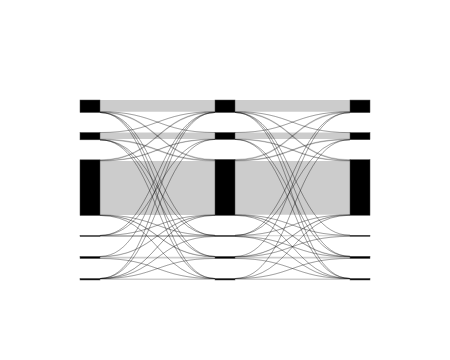

In [152]:
data123 = go.Sankey(link = link123 )
fig = go.Figure(data123)

fig.show()

Now we can see the outlines of the various cell transitions between the different land cover classes across the years. However this time it's showing the outline of the flows pre (2017-2019), and post (2019-2021) the Net-Zero target pledge. 

The same process is repeated by adding more identifiable attributes: 

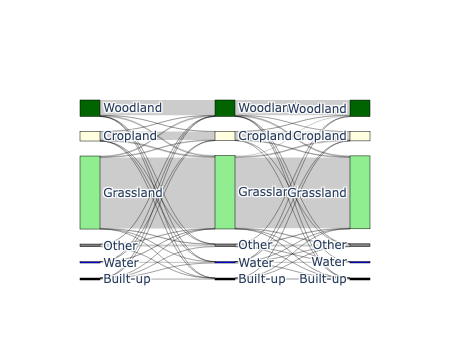

In [153]:
#labels for the sources and targets 
labels123 = lc2_names[1:] + lc2_names[1:] + lc2_names[1:]  #[1:] because we removed No Data

#and the chosen representative colours in the same order (listed prior)
colors123 =  lc2_colors[1:] + lc2_colors[1:] + lc2_colors[1:]  #[1:] because we removed No Data

#then combined in the dict to pass to node argument in sankey function
node123 = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels123 ,     
      color = colors123
    )

data123 = go.Sankey(node=node123,link = link123)
fig = go.Figure(data123)


fig.show()

Now we can see that this Sankey diagram displays the different flows and how these varied prior to, and post Net-Zero pledges. We can see that there are certain amount of cell transitions between different land covers e.g. Cropland(2017) to Grassland(2019), and then to other land covers. However, overall according to this Sankey flow diagram, there hasn't been a significant shift over to a particular type of land cover. The corresponding confusion matrices and the barcharts offer a numerical values and clearer visualisation of the extent of these changes. 

However, as mentioned before, these minimal flow changes can be attributed to the small time frame. So by looking at these land cover changes over a significantly longer period of time can we determine the significance of Net-zero impacting Scotlands land cover changes. 

### ADDITIONAL - confusion matrices between pre Net-Zero pledge (2017-2019), and post Net-Zero pledge (2019-2021)

The same code from prior can be repeated to created additional confusion matrices for those different time frames. 

This confusion matrix is for the years pre Net-Zero pledge (2017-2019): 

In [154]:
 lcm2017_scotland2_f = lcm2017_scotland2.flatten()  #flatten from 2d to 1D
lcm2019_scotland2_f = lcm2019_scotland2.flatten()  #flatten from 2d to 1D

print(lcm2019_scotland2_f.shape)

(322006,)


In [155]:
#now pass two flattened maps to the confusion matrix function 

#from sklearn import metrics
confND_1 = metrics.confusion_matrix(lcm2017_scotland2_f, lcm2019_scotland2_f)
print(confND_1.shape)
print('\n')
print(confND_1)

(7, 7)


[[243696      3      4     27      0      1      2]
 [     7  11401     53    739     19     17      4]
 [     1    109   6286    716      1     37      2]
 [    31    689    445  52855     71     36    326]
 [     0      4      1     19    952      0      0]
 [     1     14     19     61      1   1380      2]
 [     1      6      0    321      0      1   1645]]


In [156]:
#the function for this: 

def stripFirstRows(mydat):
    
    stripped = np.delete(arr=mydat, obj=0, axis=0)     #delete 0-th row
    stripped = np.delete(arr=stripped, obj=0, axis=1)  #delete 0-th col
    
    return stripped

conf_1 = stripFirstRows(confND_1)

print(conf_1.shape)
print('\n')
print(conf_1)

(6, 6)


[[11401    53   739    19    17     4]
 [  109  6286   716     1    37     2]
 [  689   445 52855    71    36   326]
 [    4     1    19   952     0     0]
 [   14    19    61     1  1380     2]
 [    6     0   321     0     1  1645]]


In [157]:
#better ndarray object
#easier though to convert to pandas dataframe and provide labels for rows e.g. an index and column names 

conf_1_pd = pd.DataFrame(conf_1,index=lc2_names[1:],columns=lc2_names[1:])
conf_1_pd
#from 2017 to 2019 - how many pixels transitioned 

,Woodland,Cropland,Grassland,Water,Built-up,Other
Woodland,11401,53,739,19,17,4
Cropland,109,6286,716,1,37,2
Grassland,689,445,52855,71,36,326
Water,4,1,19,952,0,0
Built-up,14,19,61,1,1380,2
Other,6,0,321,0,1,1645


As we can see this provides the confusion matrix which provides the numerical value of all the different pixels that transitioned to different land covers during 2017-2019. 

Now let's create the other for the years post Net-Zero pledge (2019-2021): 

In [158]:
 lcm2019_scotland2_f = lcm2019_scotland2.flatten()  #flatten from 2d to 1D
lcm2021_scotland2_f = lcm2021_scotland2.flatten()  #flatten from 2d to 1D

print(lcm2021_scotland2_f.shape)

(322006,)


In [159]:
#now pass two flattened maps to the confusion matrix function 

#from sklearn import metrics
confND_2 = metrics.confusion_matrix(lcm2019_scotland2_f, lcm2021_scotland2_f)
print(confND_2.shape)
print('\n')
print(confND_2)

(7, 7)


[[243681      5      0     46      0      1      4]
 [     7  11371     62    738     15     25      8]
 [     1     62   6215    506      0     18      6]
 [    64    844    631  52622     41     53    483]
 [     0     14      1     35    992      1      1]
 [     2      0     29     30      0   1410      1]
 [     4      7      0    408      3      1   1558]]


In [160]:
#the function for this: 

def stripFirstRows(mydat):
    
    stripped = np.delete(arr=mydat, obj=0, axis=0)     #delete 0-th row
    stripped = np.delete(arr=stripped, obj=0, axis=1)  #delete 0-th col
    
    return stripped

conf_2 = stripFirstRows(confND_2)

print(conf_2.shape)
print('\n')
print(conf_2)

(6, 6)


[[11371    62   738    15    25     8]
 [   62  6215   506     0    18     6]
 [  844   631 52622    41    53   483]
 [   14     1    35   992     1     1]
 [    0    29    30     0  1410     1]
 [    7     0   408     3     1  1558]]


In [161]:
#better ndarray object
#easier though to convert to pandas dataframe and provide labels for rows e.g. an index and column names 

conf_2_pd = pd.DataFrame(conf_2,index=lc2_names[1:],columns=lc2_names[1:])
conf_2_pd
#from 2019 to 2021 - how many pixels transitioned 

,Woodland,Cropland,Grassland,Water,Built-up,Other
Woodland,11371,62,738,15,25,8
Cropland,62,6215,506,0,18,6
Grassland,844,631,52622,41,53,483
Water,14,1,35,992,1,1
Built-up,0,29,30,0,1410,1
Other,7,0,408,3,1,1558


The same confusion matrix is created for the years post Net-Zero pledge (2019-2021). 

These matrices are useful at corresponding to the Sankey flow diagrams by providing the numerical values of those cell transitions. The Sankey diagrams help visualise these flows. From both the Sankey diagrams and the confusion matrices, there slight changes have been made towards reforestation (with increased cell transitions and flows from Grassland over to Woodland). However, the change isn't of great significance, a greater timeframe is needed to solidify the extent of land cover changes. 

## 4. Analysing Zonal Changes

We can also analyse these changes to land cover according to zones e.g. counties/unitary authorities, and display these as choropleth maps. 

Doing this requires using zonal statistics a.k.a summary statistics - e.g. mean, median, standard deviation) of all the pixels that fall within each unitary zone

### Pre done 

From before, we have already: 

- read in the vector polygon data as a GeoPandas dataframe (defined the county-level summaries to be used)
- updated the CRS attribute of the geojson file
- created the new Geodataframe to contain only Scotland's boundary polygons 
- plotted vector polygon data on top of the raster data set to ensure CRS spatial alignment 

### Zonal stats function

The `zonal_stats` function from the `rasterstats` package will be used, particularly passing these functions: 

- the Scotland polygons(Geodataframe)
- the raster data
- geospatial information for the raster data (from `transform` key of the `meta` attribute of the `rio.DatasetReader` object)
- specify `categorial=True` to ensure that counts are returned NOT other summary stats e.g. mean 

So for 2017:

In [162]:
#from rasterstats import zonal_stats
zs_scotland17_2 = zonal_stats(scotland, lcm2017_scotland2,
                           affine=lcm2017_scotland_transform,
                           categorical=True)
zs_scotland17_2  #ignore -999 warning - NoData already seems to be accounted for... (no zeros)

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahh

[{1: 19, 2: 46, 3: 76, 5: 16},
 {0: 24, 1: 1665, 2: 283, 3: 4403, 4: 20, 5: 33, 6: 6},
 {1: 228, 3: 978, 4: 9, 5: 29, 6: 31},
 {0: 2, 1: 21, 2: 427, 3: 205, 4: 1, 5: 21},
 {1: 9, 3: 136, 5: 28},
 {0: 77, 1: 9, 3: 2934, 4: 51, 5: 1, 6: 19},
 {1: 43, 2: 82, 3: 121, 5: 54},
 {0: 116, 1: 3424, 2: 409, 3: 20428, 4: 504, 5: 73, 6: 1217},
 {0: 1, 1: 20, 3: 120, 4: 2, 5: 19},
 {1: 21, 2: 83, 3: 219, 4: 2, 5: 28},
 {0: 7, 1: 592, 2: 253, 3: 1277, 5: 49, 6: 57},
 {0: 12, 1: 130, 2: 11, 3: 679, 4: 1, 5: 47, 6: 1},
 {0: 43, 3: 959, 4: 21, 5: 4, 6: 2},
 {0: 3, 1: 728, 2: 872, 3: 3108, 4: 4, 5: 24},
 {0: 124, 3: 1332, 4: 2, 5: 4, 6: 14},
 {0: 4, 1: 332, 2: 35, 3: 814, 4: 4, 5: 31},
 {1: 268, 2: 11, 3: 1411, 4: 2, 5: 81, 6: 1},
 {1: 499, 2: 172, 3: 1440, 4: 72, 5: 24, 6: 40},
 {1: 15, 2: 28, 3: 77, 5: 64},
 {0: 5, 1: 877, 2: 1748, 3: 3428, 4: 5, 5: 69, 6: 176},
 {0: 116, 1: 2104, 2: 36, 3: 4508, 4: 120, 5: 12, 6: 112},
 {0: 1, 1: 12, 2: 80, 3: 61, 5: 108},
 {1: 19, 2: 22, 3: 162, 4: 2, 5: 56},
 {1: 3

This is a `dict` for all the polygons with each pixel count for the land cover IDS. 

### Geodataframe conversion and dataframe joining 

So now we can convert this zonal stats `dict` into a Pandas Dataframe (easier for choropleth mapping):

In [163]:
zs_scotland17_2_pd = pd.DataFrame(zs_scotland17_2)
zs_scotland17_2_pd.head()

,1,2,3,5,0,4,6
0,19.0,46.0,76,16,NaN,NaN,NaN
1,1665.0,283.0,4403,33,24.0,20.0,6.0
2,228.0,NaN,978,29,NaN,9.0,31.0
3,21.0,427.0,205,21,2.0,1.0,NaN
4,9.0,NaN,136,28,NaN,NaN,NaN


Now are data has to be joined in order for it plotted (requires the geometry info). This requires: 

- setting the same index
- adding column names (suffix included to make it distinguishable from other years)

In [164]:
zs_scotland17_2_pd.set_index(scotland.index,inplace=True)
zs_scotland17_2_pd.rename(columns=lclabs,inplace=True)
zs_scotland17_2_pd = zs_scotland17_2_pd.add_suffix('17')
zs_scotland17_2_pd.head()

,Woodland17,Cropland17,Grassland17,Built-up17,No Data17,Water17,Other17
ctyua19nm,,,,,,,
Clackmannanshire,19.0,46.0,76,16,NaN,NaN,NaN
Dumfries and Galloway,1665.0,283.0,4403,33,24.0,20.0,6.0
East Ayrshire,228.0,NaN,978,29,NaN,9.0,31.0
East Lothian,21.0,427.0,205,21,2.0,1.0,NaN
East Renfrewshire,9.0,NaN,136,28,NaN,NaN,NaN


Joining the original Scotland dataframe by creating a completely new object: 

In [165]:
scotland_gpd = pd.merge(scotland, zs_scotland17_2_pd, how='left', left_index=True, right_index=True)
scotland_gpd.head()

,objectid,ctyua19cd,ctyua19nmw,bng_e,bng_n,long,lat,st_areashape,st_lengthshape,geometry,Woodland17,Cropland17,Grassland17,Built-up17,No Data17,Water17,Other17
ctyua19nm,,,,,,,,,,,,,,,,,
Clackmannanshire,152,S12000005,,291159,696335,-3.75344,56.147240,1.589764e+08,9.086602e+04,"MULTIPOLYGON (((290674.509 703671.499, 290009....",19.0,46.0,76,16,NaN,NaN,NaN
Dumfries and Galloway,153,S12000006,,270645,579857,-4.02863,55.096218,6.437726e+09,1.048454e+06,"MULTIPOLYGON (((207653.609 541738.872, 207676....",1665.0,283.0,4403,33,24.0,20.0,6.0
East Ayrshire,154,S12000008,,255398,624935,-4.29057,55.496738,1.270369e+09,3.309121e+05,"POLYGON ((258813.515 645129.307, 258733.010 64...",228.0,NaN,978,29,NaN,9.0,31.0
East Lothian,155,S12000010,,354854,672351,-2.72435,55.942070,6.792207e+08,1.908342e+05,"MULTIPOLYGON (((351116.011 686149.004, 351032....",21.0,427.0,205,21,2.0,1.0,NaN
East Renfrewshire,156,S12000011,,251929,653115,-4.36060,55.748680,1.742541e+08,9.178945e+04,"POLYGON ((258954.209 656913.104, 259036.709 65...",9.0,NaN,136,28,NaN,NaN,NaN


### Choropleth Map - total Woodland land cover in Scotland (2017)

Now we can plot the total amount of Woodland in Scotland in 2017: 

<AxesSubplot: >

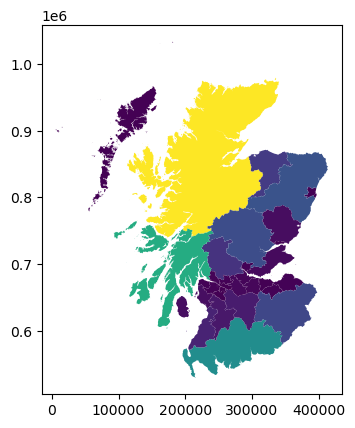

In [166]:
scotland_gpd.plot('Woodland17')

Let's add a legend to make the colours easily identifiable: 

<AxesSubplot: >

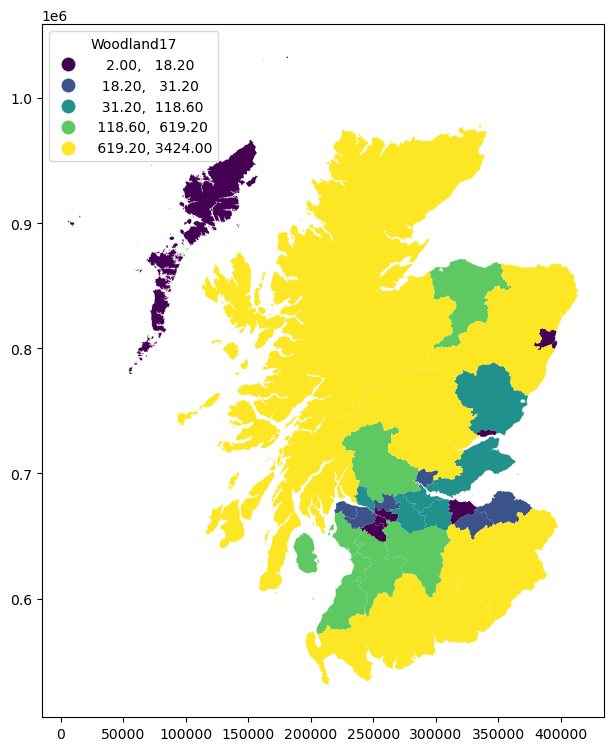

In [167]:
col = 'Woodland17'

fig, ax = plt.subplots(1, figsize=(9, 9))

scotland_gpd.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )

### Choropleth Map - Total Woodland land cover change in Scotland pre Net-Zero pledge (2017-2019)

We can repeat this same code to calculate the values for the year 2019: 

In [168]:
zs_scotland19_2 = zonal_stats(scotland_gpd, lcm2019_scotland2,
                           affine=lcm2019_scotland_transform,
                           categorical=True)
zs_scotland19_2_pd = pd.DataFrame(zs_scotland19_2)
zs_scotland19_2_pd.set_index(scotland_gpd.index,inplace=True)
zs_scotland19_2_pd.rename(columns=lclabs,inplace=True)
zs_scotland19_2_pd = zs_scotland19_2_pd.add_suffix('19')
scotland_gpd = scotland_gpd.join(zs_scotland19_2_pd, how='left')

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahh

Let's check to see if the columns for those land covers (2017 and 2019) have been addedd to the Geodataframe: 

In [169]:
scotland_gpd.columns

Index(['objectid', 'ctyua19cd', 'ctyua19nmw', 'bng_e', 'bng_n', 'long', 'lat',
       'st_areashape', 'st_lengthshape', 'geometry', 'Woodland17',
       'Cropland17', 'Grassland17', 'Built-up17', 'No Data17', 'Water17',
       'Other17', 'Woodland19', 'Cropland19', 'Grassland19', 'Built-up19',
       'No Data19', 'Water19', 'Other19'],
      dtype='object')

As both 'Woodland17'and 'Woodland19' are there, the difference in land cover change can be calculated and added to the Geodataframe: 

In [170]:
scotland_gpd['Woodland_17-19'] = scotland_gpd['Woodland19'] - scotland_gpd['Woodland17']

This change in land cover can then also be plotted via a choropleth map: 

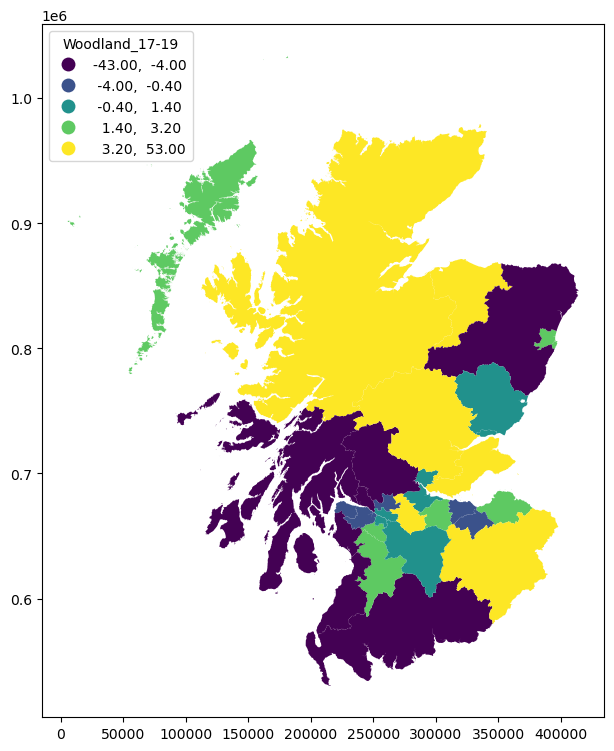

In [171]:
col='Woodland_17-19'

fig, ax = plt.subplots(1, figsize=(9, 9))

scotland_gpd.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )

plt.show()

These maps provide a baseline spatial visualisation the total Woodland land cover and land cover change during 2017-2019. However, both these maps can be easily improved. 

### Map Improvements 

These maps will be specifically by: 

- incorporating a spatially intensive variable of Woodland change - % change for the counties/unitary authorities 
- use a more appropriate divergent colour scheme that better represents the incline/decline of Woodland 

### County-level percentage change - pre Net-Zero (2017-2019) 

This requires creating a new variable (in Geodataframe) for the total area of each county: 

In [172]:
scotland_gpd['Sum19'] = scotland_gpd.loc[:,'Grassland19':'Other19'].sum(axis=1)   #axis=1 to sum rows 

Then calculate the percentage change: 

In [173]:
scotland_gpd['Woodland_17-19Perc'] = 100* scotland_gpd['Woodland_17-19'] / scotland_gpd['Sum19']

This percentage change can then be plotted as a choropleth map: 

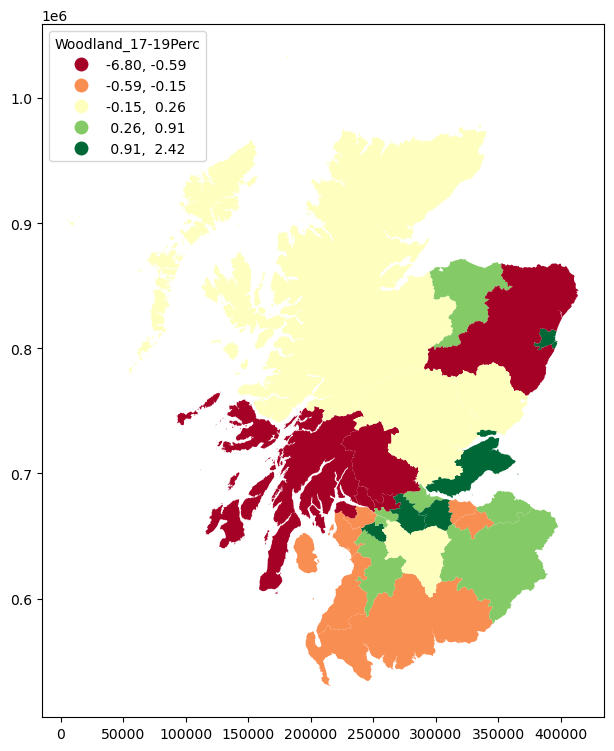

In [174]:
col='Woodland_17-19Perc'

fig, ax = plt.subplots(1, figsize=(9, 9))

scotland_gpd.plot(column=col, cmap='RdYlGn', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )

plt.show()

This now visualises the percentage change in Scotland's Woodland land cover pre Net-Zero pledge (2017-2019).

Whilst this is an improvement from using total count, the visual component can still be improved by the use of a UserDefined classification scheme alongside a ListedColormap. 

Lets look at the variable distribution to help decide the type of classification and colour scheme to use: 

<AxesSubplot: >

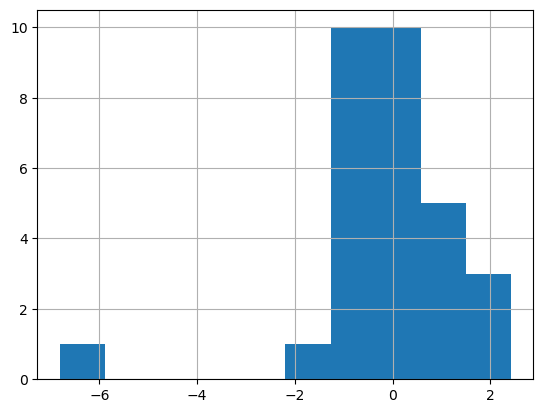

In [175]:
scotland_gpd['Woodland_17-19Perc'].hist()

 ### County-level percentage change - post Net-Zero (2019-2021) 

Let us quickly repeat the same process for the years 2019-2021 so that we can compare land cover changes through the choropleth maps:  

In [176]:
zs_scotland21_2 = zonal_stats(scotland_gpd, lcm2021_scotland2,
                           affine=lcm2021_scotland_transform,
                           categorical=True)
zs_scotland21_2_pd = pd.DataFrame(zs_scotland21_2)
zs_scotland21_2_pd.set_index(scotland_gpd.index,inplace=True)
zs_scotland21_2_pd.rename(columns=lclabs,inplace=True)
zs_scotland21_2_pd = zs_scotland21_2_pd.add_suffix('21')
scotland_gpd = scotland_gpd.join(zs_scotland21_2_pd, how='left')

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahhasni/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly

/Users/bahriyahh

In [178]:
scotland_gpd['Woodland_19-21'] = scotland_gpd['Woodland21'] - scotland_gpd['Woodland19']

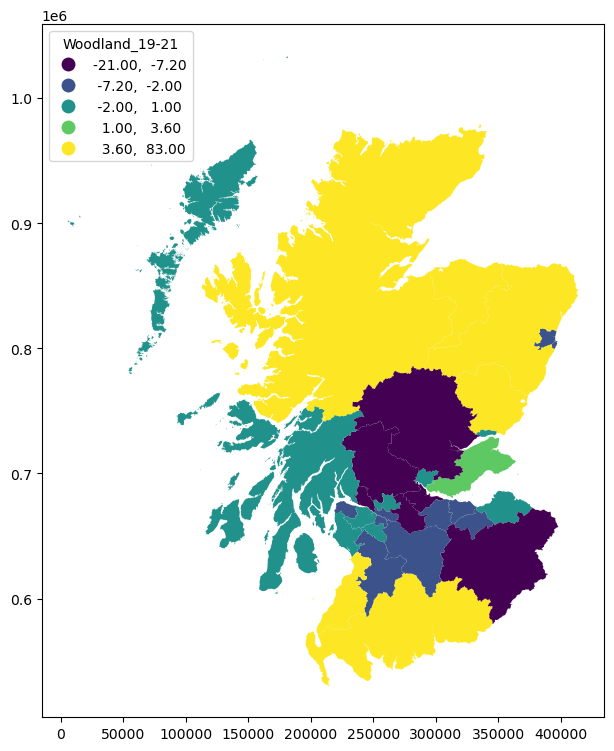

In [179]:
col='Woodland_19-21'

fig, ax = plt.subplots(1, figsize=(9, 9))

scotland_gpd.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )

plt.show()

This visualises the total Woodland land cover alongside a corresponding legend, however, as mentioned prior this can be improved by using percentage change instead: 

In [180]:
scotland_gpd['Sum21'] = scotland_gpd.loc[:,'Grassland21':'Other21'].sum(axis=1)   #axis=1 to sum rows 
scotland_gpd['Woodland_19-21Perc'] = 100* scotland_gpd['Woodland_19-21'] / scotland_gpd['Sum21']

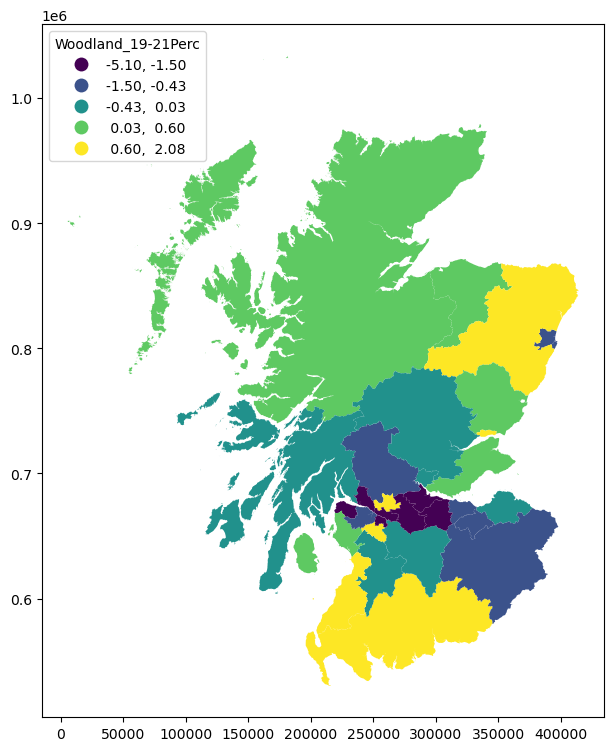

In [181]:
col='Woodland_19-21Perc'

fig, ax = plt.subplots(1, figsize=(9, 9))

scotland_gpd.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )

plt.show()

Now this visualises Scotland's Woodland percentage change in land cover post Net-Zero pledge (2019-2021). However, to compare both the post and pre years, it's best to use the same classification scheme as well as a relevant colourmap. 

<AxesSubplot: >

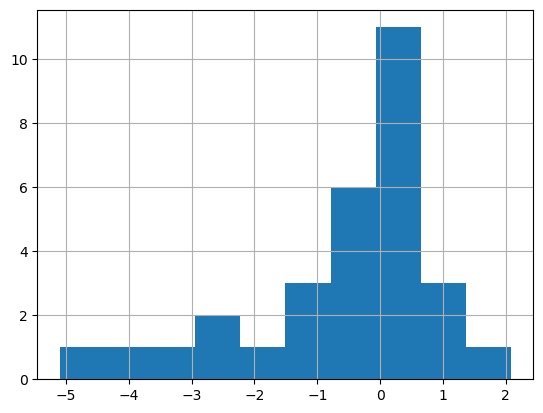

In [182]:
scotland_gpd['Woodland_19-21Perc'].hist()

<AxesSubplot: >

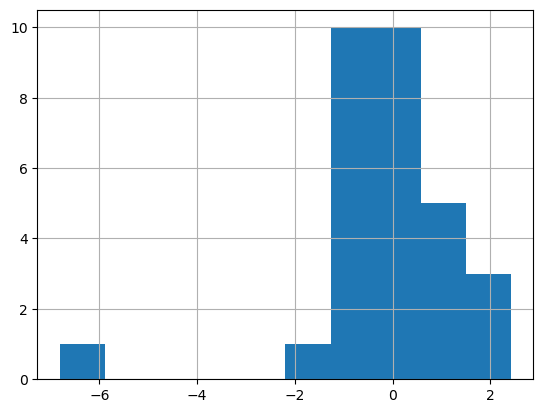

In [183]:
scotland_gpd['Woodland_17-19Perc'].hist()

### County-level Change - choropleth maps of the percentage change of Scotland's Woodland cover pre Net-Zero (2017-2019) and post Net-Zero pledge (2019-2021)

The histograms plotted of the variables distribution proves very useful when defining the specific bin ranges and colour as well: 

In [184]:
#bins from histogram check above but centred on zero
woodbins = [-12,-8,-4,0,4,8]  #mapclassify.UserDefined requires upper bounds of class bins 
woodcolors = ["#de77ae","#f1b6da", "#fde0ef", "#e6f5d0", "#b8e186", "#7fbc41", "#4d9221"] #create list for map legend below
woodcmap = ListedColormap(woodcolors)

Now we can plot the initial choropleth map of the pre Net-Zero years (2017-2019) using the my defined classification and colour scheme: 

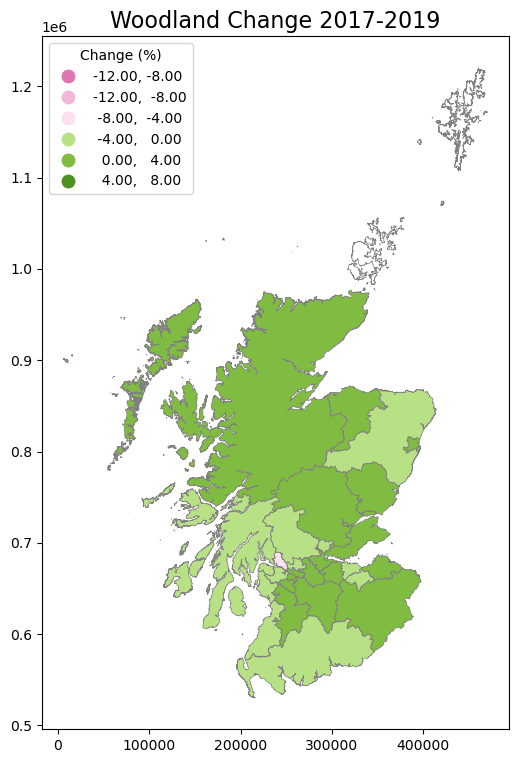

In [186]:
fig, ax = plt.subplots(1, figsize=(9, 9))

scotland_gpd.plot(column='Woodland_17-19Perc', 
    cmap=woodcmap, 
    scheme='UserDefined', 
    classification_kwds={'bins': woodbins},  #provide the user-created (upper) bin limits here
    legend=True, legend_kwds={"title":"Change (%)","loc": 2}, ax=ax
)

scotland_gpd.plot(ax=ax, facecolor='None', edgecolor='grey', linewidth=0.5)

#edit legend labels
leg = ax.get_legend()
leg.get_texts()[0].set_text('-12.00, -8.00')

plt.title("Woodland Change 2017-2019", size=16)
plt.show()

Now I can plot two choropleth maps visualising the percentage change in Woodland cover pre Net-Zero (2017-2019), and post Net-Zero (2019-2021), using the classification and specific colour scheme identified above: 

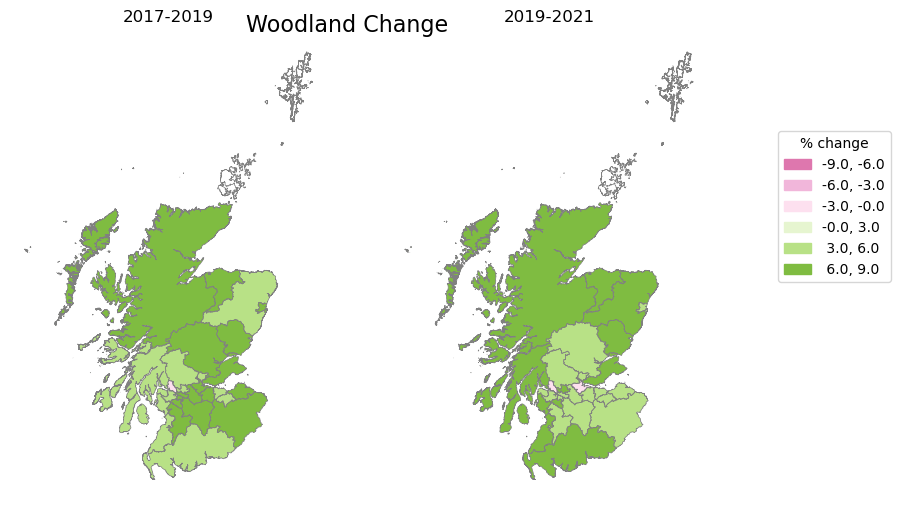

In [191]:
fig, axes = plt.subplots(1,2, figsize=(9, 9))

scotland_gpd.plot(column='Woodland_17-19Perc', 
    cmap=woodcmap, 
    scheme='UserDefined', 
    classification_kwds={'bins': woodbins},
    legend=False, ax=axes[0]
)

scotland_gpd.plot(column='Woodland_19-21Perc', 
    cmap=woodcmap, 
    scheme='UserDefined', 
    classification_kwds={'bins': woodbins},
    legend=False, ax=axes[1]
)

scotland_gpd.plot(ax=axes[0], facecolor='None', edgecolor='grey', linewidth=0.5)
scotland_gpd.plot(ax=axes[1], facecolor='None', edgecolor='grey', linewidth=0.5)

axes[0].set_axis_off()
axes[1].set_axis_off()

axes[0].set_title('2017-2019')
axes[1].set_title('2019-2021')

# use zip to combine two lists into a dict
legend_wood = dict(zip(woodcolors, woodbins))

#from matplotlib.patches import Patch
patches = [Patch(color=color, label=label)
           for color, label in legend_wood.items()]

#add legend!
axes[1].legend(handles=patches,
        bbox_to_anchor=(1.6, 0.8),
        facecolor="white",
        title='% change')

#edit legend labels
leg = axes[1].get_legend()
leg.get_texts()[0].set_text('-9.0, -6.0')
leg.get_texts()[1].set_text('-6.0, -3.0')
leg.get_texts()[2].set_text('-3.0, -0.0')
leg.get_texts()[3].set_text('-0.0, 3.0')
leg.get_texts()[4].set_text(' 3.0, 6.0')
leg.get_texts()[5].set_text(' 6.0, 9.0')


plt.suptitle("Woodland Change", size=16, y=0.775)
plt.show()

I have created 2 finalised choropleth maps that depict the percentage change in Scotland's Woodland cover from the years pre Net-Zero (2017-2019) and the years post Net-Zero pledge (2019-2021). These are both classified according to the same colour scheme and using the same bin ranges to enable ease of comparison. 

From these maps it can be inferred that there has overall been a increase in Woodland land cover shown by most of the northern regions being coloured in the dark green bin. There does appear to be a slight decrease in the Southern parts of Scotland post Net-Zero, however, overall there appears to be a positive trend. Albeit the changes are around 6-9% increases (according to this map), so if considering a longer time frame, perhaps the increase in Woodland may be continued. This would reinforce the findings from the previous data analysis and visualisations that the pledges are having a positive impact at inducing greater reforestation efforts for Scotland. 